## Evaluation of average models evaluated on each region of evaluate dataset
Using dataset average connectivity models, we evaluate regions in the eval_dataset separately


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
from statannotations.Annotator import Annotator
import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as at
import glob
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import SUITPy as suit
import nitools as nt
from itertools import combinations

In [2]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1],colorbar=False):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale, colorbar=colorbar)

### Using half estimation

In [3]:
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds != dataset_name]

    # Load avg region performances
    df = rm.comb_eval(models=[dataset_name+"-avg-region"],methods=['L2reghalf'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])

    # Load loo region performances
    df = rm.comb_eval(models=[dataset_name+"-loo-region"],methods=['L2reghalf'],eval_data=[dataset_name],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all = pd.concat([df_all, df])

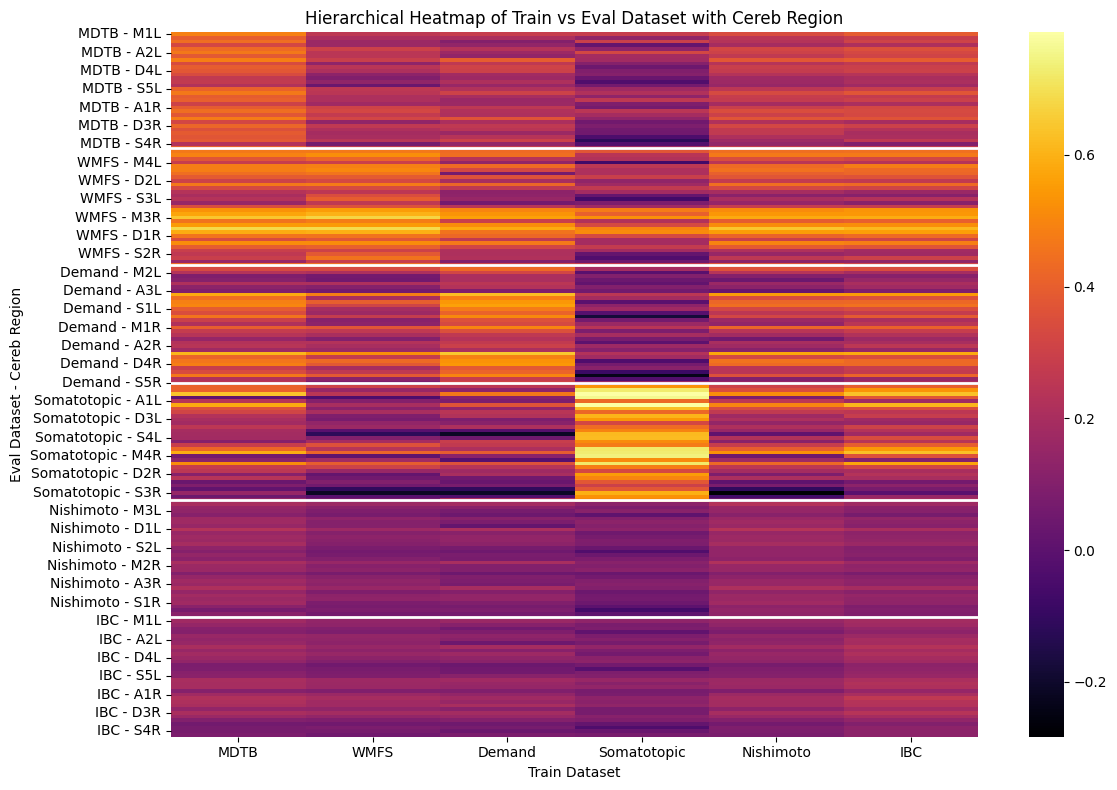

In [4]:
df_all['combined_index'] = df_all['eval_dataset'] + " - " + df_all['cereb_region_name']

# Pivot the data to create a hierarchical structure
heatmap_data = pd.pivot_table(df_all, values='R_eval', index='combined_index', columns='train_dataset')
heatmap_data = heatmap_data.reindex(index=[f"{eval_ds} - {region}" for eval_ds in dataset_list for region in df_all['cereb_region_name'].unique()],
                                    columns=dataset_list)


# Create the hierarchical heatmap
fig = plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='inferno', annot=False, fmt=".2f", cbar=True)

# Add horizontal lines where each eval_dataset ends
for i, eval_ds in enumerate(dataset_list[:-1]):
    end_index = df_all[df_all['eval_dataset'] == eval_ds]['combined_index'].iloc[-1]
    plt.axhline(y=heatmap_data.index.get_loc(end_index) + 0.5, color='white', linewidth=2)

# Customize the axes
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset - Cereb Region')
plt.title('Hierarchical Heatmap of Train vs Eval Dataset with Cereb Region')
plt.tight_layout()
plt.show()

# fig.savefig('region_heatmap.png', dpi=300, bbox_inches='tight')

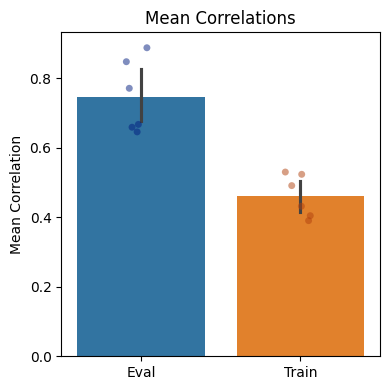

In [5]:
# Initialize a dictionary to store the mean correlations for each /traineval_dataset
mean_correlations_train = {}
mean_correlations_eval = {}

# Iterate over each eval_dataset
for ds in dataset_list:
    # Filter the heatmap_data for the current train/eval_dataset
    train_data = heatmap_data[ds]
    eval_data = heatmap_data.loc[heatmap_data.index.str.startswith(ds)]
    
    # Extract the 32-length vectors for each train/eval_dataset
    train_vectors = train_data.values.reshape(-1, 32)  # Reshape to ensure correct dimensions
    eval_vectors = eval_data.T.values  # Transpose to get train_dataset as rows
    
    # Calculate correlations for all possible pairs of train/eval datasets
    train_correlations = []
    eval_correlations = []
    for ds1, ds2 in combinations(range(train_vectors.shape[0]), 2):
        corr = np.corrcoef(eval_vectors[ds1], eval_vectors[ds2])[0, 1]
        eval_correlations.append(corr)

        corr = np.corrcoef(train_vectors[ds1], train_vectors[ds2])[0, 1]
        train_correlations.append(corr)
    
    # Calculate the mean correlation for the current train/eval_dataset
    mean_correlations_eval[ds] = np.array(eval_correlations)
    mean_correlations_train[ds] = np.array(train_correlations)

# Create a DataFrame for the mean correlations
mean_corr_df = pd.DataFrame({
    'Dataset': dataset_list,
    'Eval': [np.mean(mean_correlations_eval[ds]) for ds in dataset_list],
    'Train': [np.mean(mean_correlations_train[ds]) for ds in dataset_list]
}).set_index('Dataset')

# Create a bar plot for the mean correlations
plt.figure(figsize=(4, 4))
sns.barplot(data=mean_corr_df)
sns.stripplot(data=mean_corr_df, palette='dark', alpha=0.5, marker='o')
plt.ylabel('Mean Correlation')
plt.title('Mean Correlations')
plt.tight_layout()
plt.show()

In [ ]:
# Initialize a dictionary to store the mean correlations for each /traineval_dataset
mean_correlations_train = {}
mean_correlations_eval = {}

# Iterate over each eval_dataset
for ds in dataset_list:
    # Filter the heatmap_data for the current train/eval_dataset
    train_data = heatmap_data[ds]
    eval_data = heatmap_data.loc[heatmap_data.index.str.startswith(ds)]
    
    # Extract the 32-length vectors for each train/eval_dataset
    train_vectors = train_data.values.reshape(-1, 32)  # Reshape to ensure correct dimensions
    eval_vectors = eval_data.T.values  # Transpose to get train_dataset as rows
    
    # Calculate correlations for all possible pairs of train/eval datasets
    train_correlations = []
    eval_correlations = []
    for ds1, ds2 in combinations(range(train_vectors.shape[0]), 2):
        corr = np.corrcoef(eval_vectors[ds1], eval_vectors[ds2])[0, 1]
        eval_correlations.append(corr)

        corr = np.corrcoef(train_vectors[ds1], train_vectors[ds2])[0, 1]
        train_correlations.append(corr)
    
    # Calculate the mean correlation for the current train/eval_dataset
    mean_correlations_eval[ds] = np.array(eval_correlations)
    mean_correlations_train[ds] = np.array(train_correlations)

# Create a DataFrame for the mean correlations
mean_corr_df = pd.DataFrame({
    'Dataset': dataset_list,
    'Eval': [np.mean(mean_correlations_eval[ds]) for ds in dataset_list],
    'Train': [np.mean(mean_correlations_train[ds]) for ds in dataset_list]
}).set_index('Dataset')

# Create a bar plot for the mean correlations
plt.figure(figsize=(4, 4))
sns.barplot(data=mean_corr_df)
sns.stripplot(data=mean_corr_df, palette='dark', alpha=0.5, marker='o')
plt.ylabel('Mean Correlation')
plt.title('Mean Correlations')
plt.tight_layout()

### Average performance on regions

In [6]:
atlas, _ = at.get_atlas('MNISymC3')
atlas_dir = '/cifs/diedrichsen/data/FunctionalFusion/Atlases/tpl-MNI152NLin2009cSymC'
atlas_fname = 'atl-NettekovenSym32_space-MNI152NLin2009cSymC_probseg.nii'
U = atlas.read_data(f'{atlas_dir}/{atlas_fname}').T
atlas_labels = np.argmax(U, axis=1)+1
_, _, atlas_names = nt.read_lut(f'{atlas_dir}/atl-NettekovenSym32.lut')

In [7]:
# Group by train_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = heatmap_data.groupby(heatmap_data.index.str.split(' - ').str[1]).mean().T

# Create a dictionary to store the vectors for each train_dataset
R_map_dic = {}
for train_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        vector[i] = average_r_eval.loc[train_dataset, atlas_names[label]]
    R_map_dic[train_dataset] = vector

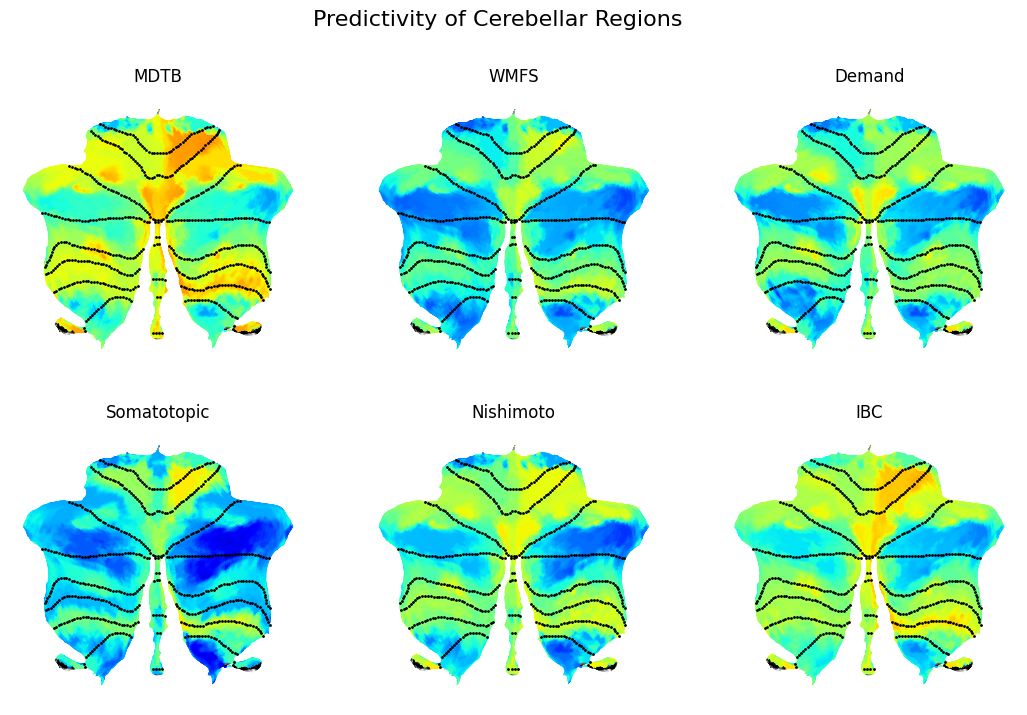

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictivity of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[0.0, 0.5])
    plt.title(dataset_name)
# fig.savefig('predictivity_region.png', dpi=300, bbox_inches='tight')

In [12]:
# Group by eval_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = pd.DataFrame(index=dataset_list, columns=atlas_names[1:])
for ev_ds in dataset_list:
    for region in atlas_names[1:]:
        average_r_eval.loc[ev_ds, region] = heatmap_data.loc[f"{ev_ds} - {region}", :].mean()

# Create a dictionary to store the vectors for each eval_dataset
R_map_dic = {}
for eval_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        vector[i] = average_r_eval.loc[eval_dataset, atlas_names[label]]
    R_map_dic[eval_dataset] = vector

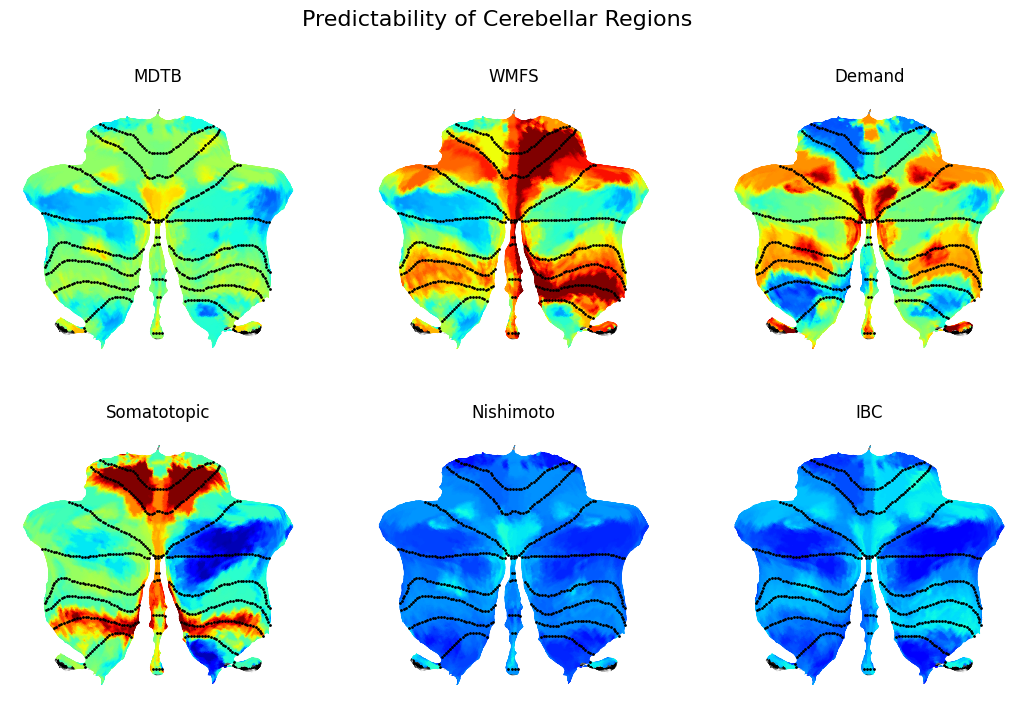

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictability of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[0.0, 0.5])
    plt.title(dataset_name)
# fig.savefig('predictability_region.png', dpi=300, bbox_inches='tight')

### Average across regions to obtain 4 domains

In [14]:
# Find indices where atlas_names starts with 'M', 'D', 'S', or 'A'
indices_M = [i for i, name in enumerate(atlas_names) if name.startswith('M')]
indices_A = [i for i, name in enumerate(atlas_names) if name.startswith('A')]
indices_D = [i for i, name in enumerate(atlas_names) if name.startswith('D')]
indices_S = [i for i, name in enumerate(atlas_names) if name.startswith('S')]

print("Indices starting with 'M':", indices_M)
print("Indices starting with 'A':", indices_A)
print("Indices starting with 'D':", indices_D)
print("Indices starting with 'S':", indices_S)

# Count the occurrences of each index in atlas_labels
n_count_M = [np.sum(atlas_labels == idx) for idx in indices_M]
n_count_A = [np.sum(atlas_labels == idx) for idx in indices_A]
n_count_D = [np.sum(atlas_labels == idx) for idx in indices_D]
n_count_S = [np.sum(atlas_labels == idx) for idx in indices_S]

print("Counts for indices starting with 'M':", n_count_M)
print("Counts for indices starting with 'A':", n_count_A)
print("Counts for indices starting with 'D':", n_count_D)
print("Counts for indices starting with 'S':", n_count_S)

Indices starting with 'M': [1, 2, 3, 4, 17, 18, 19, 20]
Indices starting with 'A': [5, 6, 7, 21, 22, 23]
Indices starting with 'D': [8, 9, 10, 11, 24, 25, 26, 27]
Indices starting with 'S': [12, 13, 14, 15, 16, 28, 29, 30, 31, 32]
Counts for indices starting with 'M': [74, 265, 284, 136, 41, 204, 284, 136]
Counts for indices starting with 'A': [38, 96, 35, 38, 96, 35]
Counts for indices starting with 'D': [166, 349, 416, 63, 163, 348, 383, 62]
Counts for indices starting with 'S': [249, 424, 19, 160, 19, 245, 421, 18, 160, 19]


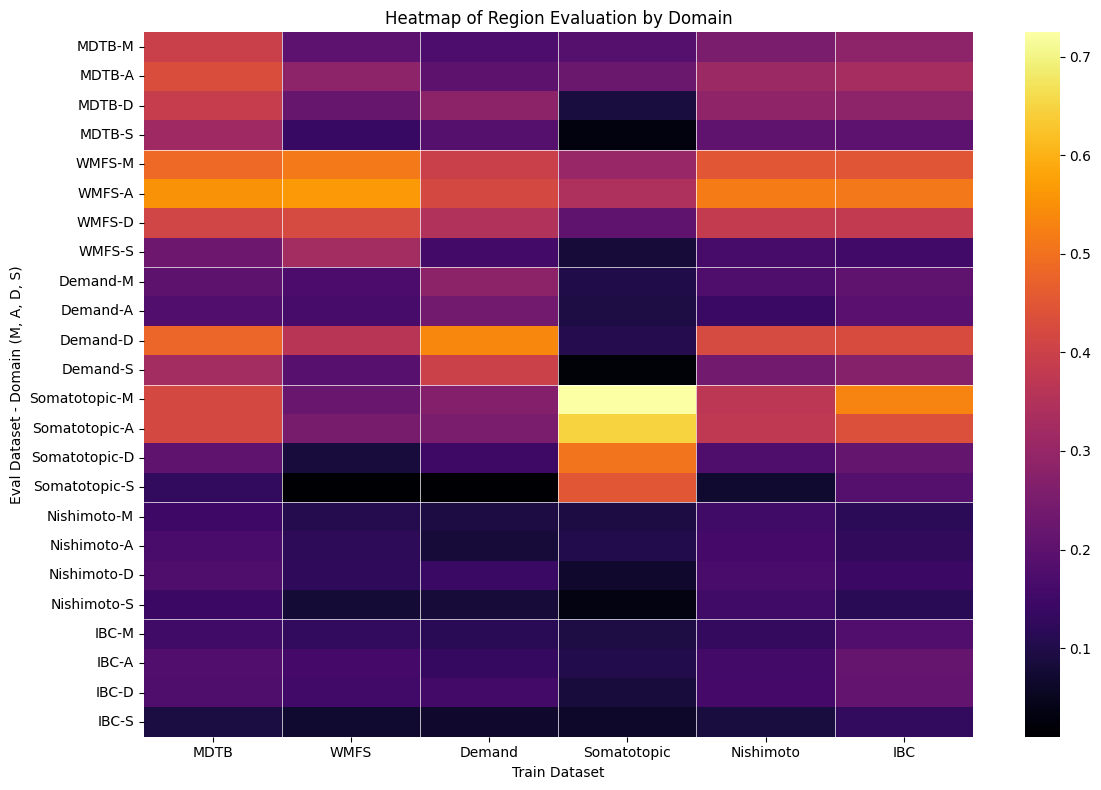

In [15]:
# Create a pivot table for the heatmap
heatmap_data = pd.pivot_table(df_all, values='R_eval', index=['eval_dataset', 'cereb_region_num'], columns='train_dataset')

# Perform weighted averages for each domain (M, A, D, S)
heatmap_data_domain = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_list, ['M', 'A', 'D', 'S']]), columns=dataset_list)

for eval_ds in dataset_list:
    heatmap_data_domain.loc[(eval_ds, 'M')] = heatmap_data.loc[(eval_ds, indices_M), :].multiply(n_count_M, axis=0).sum(axis=0) / np.sum(n_count_M)
    heatmap_data_domain.loc[(eval_ds, 'A')] = heatmap_data.loc[(eval_ds, indices_A), :].multiply(n_count_A, axis=0).sum(axis=0) / np.sum(n_count_A)
    heatmap_data_domain.loc[(eval_ds, 'D')] = heatmap_data.loc[(eval_ds, indices_D), :].multiply(n_count_D, axis=0).sum(axis=0) / np.sum(n_count_D)
    heatmap_data_domain.loc[(eval_ds, 'S')] = heatmap_data.loc[(eval_ds, indices_S), :].multiply(n_count_S, axis=0).sum(axis=0) / np.sum(n_count_S)

# Plot the heatmap for the weighted averages
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_domain.astype(float), cmap='inferno', annot=False, fmt=".2f", cbar=True)

# Add horizontal lines where each eval_dataset ends
for i, eval_ds in enumerate(dataset_list[:-1]):
    plt.axhline(y=heatmap_data_domain.index.get_loc((eval_ds, 'S')) + 1, color='white', linewidth=0.5)
# Add vertical lines where each train_dataset ends
for j, train_ds in enumerate(dataset_list[:-1]):
    plt.axvline(x=j + 1, color='white', linewidth=0.5)

plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset - Domain (M, A, D, S)')
plt.title('Heatmap of Region Evaluation by Domain')
plt.tight_layout()
plt.show()

In [16]:
average_r_eval_domain = heatmap_data_domain.groupby(level=1).mean().T

# Create a dictionary to store the vectors for each train_dataset
R_map_dic = {}
for train_dataset in average_r_eval_domain.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in indices_M:
            vector[i] = average_r_eval_domain.loc[train_dataset, 'M']
        elif label in indices_A:
            vector[i] = average_r_eval_domain.loc[train_dataset, 'A']
        elif label in indices_D:
            vector[i] = average_r_eval_domain.loc[train_dataset, 'D']
        elif label in indices_S:
            vector[i] = average_r_eval_domain.loc[train_dataset, 'S']
    R_map_dic[train_dataset] = vector

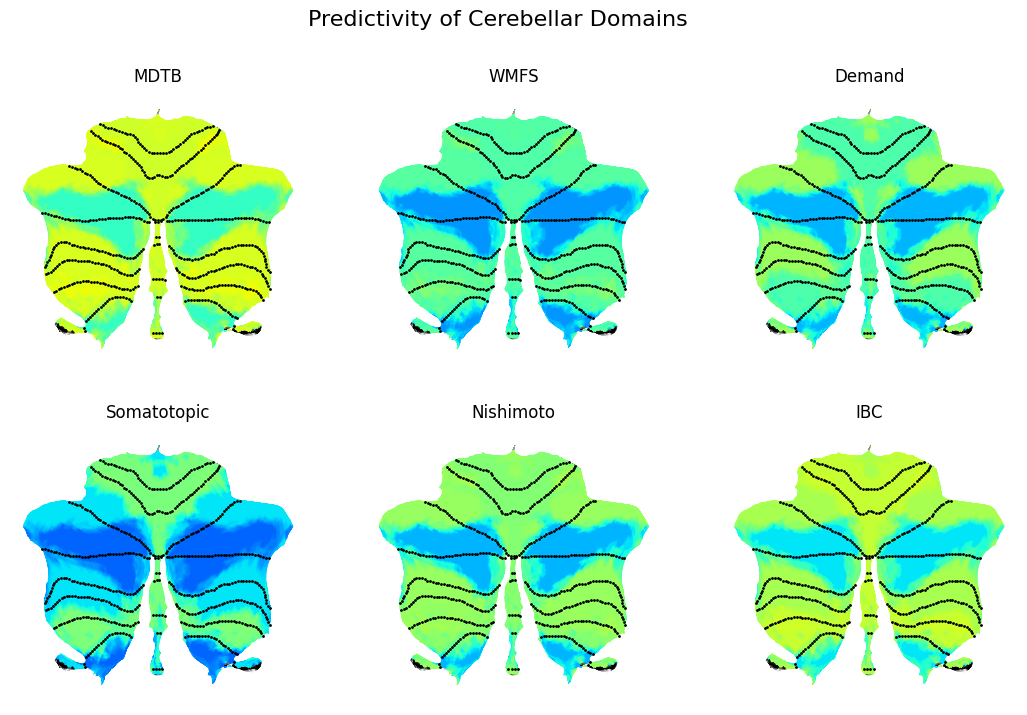

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictivity of Cerebellar Domains', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[0.0, 0.5])
    plt.title(dataset_name)
# fig.savefig('predictivity_region.png', dpi=300, bbox_inches='tight')

In [18]:
average_r_eval_domain = heatmap_data_domain.mean(axis=1).unstack(level=1).reindex(index=dataset_list, columns=['M', 'A', 'D', 'S'])

# Create a dictionary to store the vectors for each eval_dataset
R_map_dic = {}
for eval_dataset in average_r_eval_domain.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in indices_M:
            vector[i] = average_r_eval_domain.loc[eval_dataset, 'M']
        elif label in indices_A:
            vector[i] = average_r_eval_domain.loc[eval_dataset, 'A']
        elif label in indices_D:
            vector[i] = average_r_eval_domain.loc[eval_dataset, 'D']
        elif label in indices_S:
            vector[i] = average_r_eval_domain.loc[eval_dataset, 'S']
    R_map_dic[eval_dataset] = vector

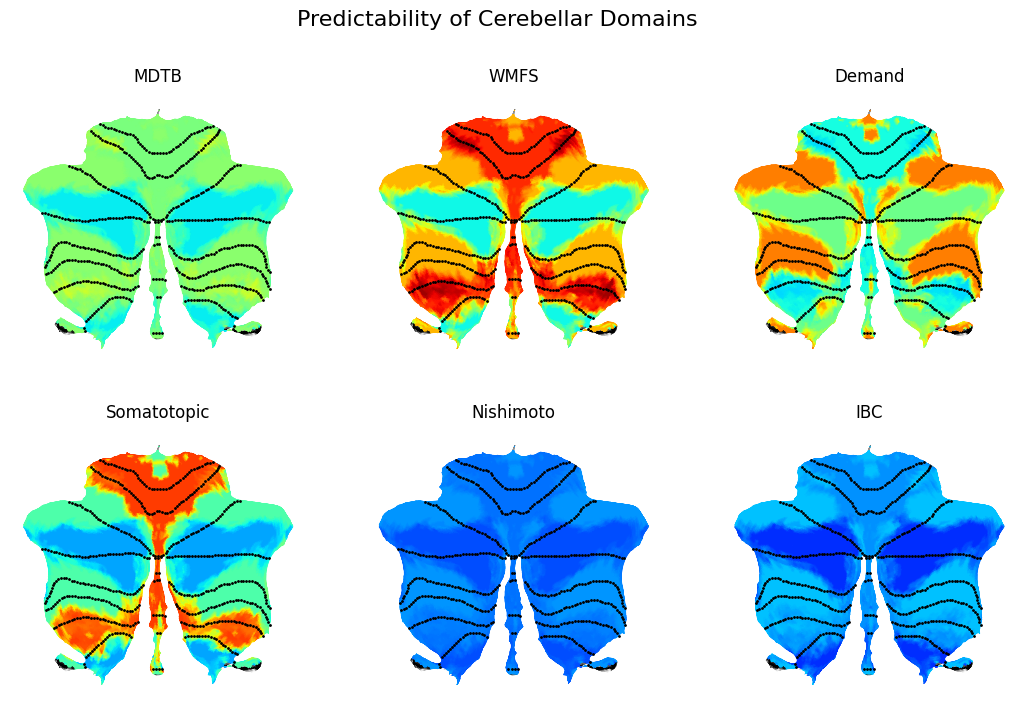

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictability of Cerebellar Domains', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[0.0, 0.5])
    plt.title(dataset_name)
# fig.savefig('predictability_region.png', dpi=300, bbox_inches='tight')

### Replication with L2reg

In [ ]:
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds != dataset_name]

    # Load region performances
    df = rm.comb_eval(models=[dataset_name+"-avg-region"],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])

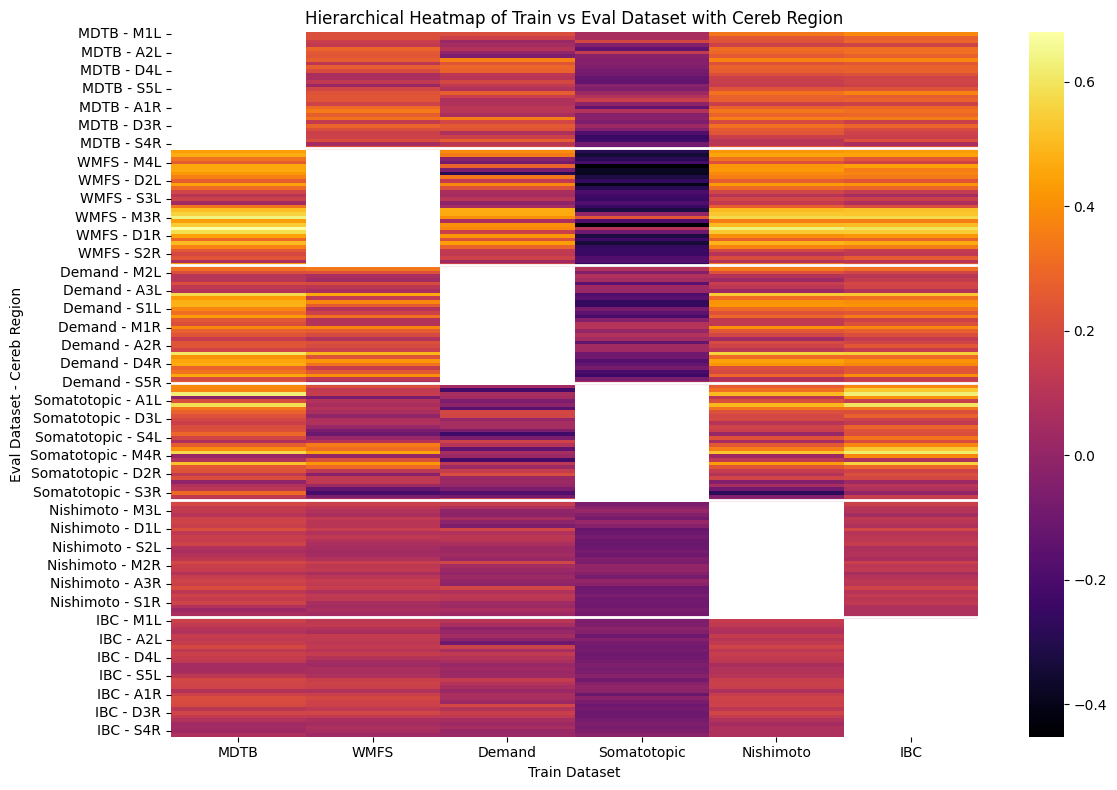

In [36]:
df_all['combined_index'] = df_all['eval_dataset'] + " - " + df_all['cereb_region_name']

# Pivot the data to create a hierarchical structure
heatmap_data = pd.pivot_table(df_all, values='R_eval', index='combined_index', columns='train_dataset')
heatmap_data = heatmap_data.reindex(index=[f"{eval_ds} - {region}" for eval_ds in dataset_list for region in df_all['cereb_region_name'].unique()],
                                    columns=dataset_list)

# Create the hierarchical heatmap
fig = plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='inferno', annot=False, fmt=".2f", cbar=True)

# Add horizontal lines where each eval_dataset ends
for i, eval_ds in enumerate(dataset_list[:-1]):
    end_index = df_all[df_all['eval_dataset'] == eval_ds]['combined_index'].iloc[-1]
    plt.axhline(y=heatmap_data.index.get_loc(end_index) + 0.5, color='white', linewidth=2)

# Customize the axes
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset - Cereb Region')
plt.title('Hierarchical Heatmap of Train vs Eval Dataset with Cereb Region')
plt.tight_layout()
plt.show()

In [37]:
# Group by train_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = df_all.groupby(['train_dataset', 'cereb_region_num'])['R_eval'].mean().unstack().reindex(dataset_list)

# Create a dictionary to store the vectors for each train_dataset
R_map_dic = {}
for train_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in average_r_eval.columns:
            vector[i] = average_r_eval.loc[train_dataset, label]
    R_map_dic[train_dataset] = vector

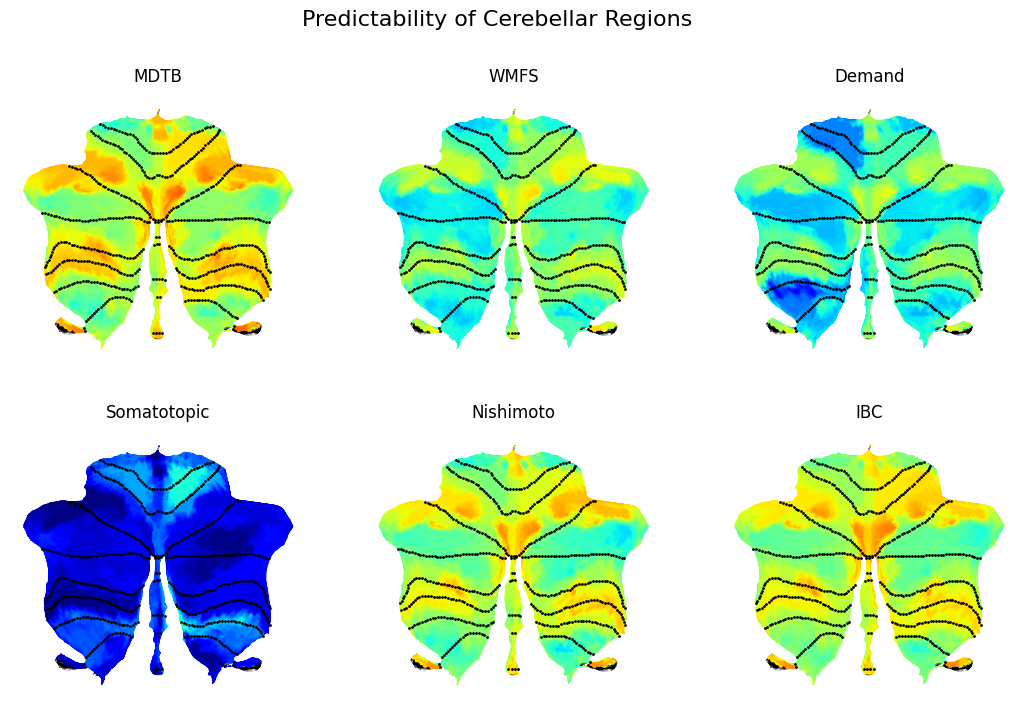

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictability of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[-0.2, 0.6])
    plt.title(dataset_name)

In [39]:
# Group by eval_dataset and cereb_region_name, then calculate the mean of R_eval
average_r_eval = df_all.groupby(['eval_dataset', 'cereb_region_num'])['R_eval'].mean().unstack().reindex(dataset_list)

# Create a dictionary to store the vectors for each eval_dataset
R_map_dic = {}
for eval_dataset in average_r_eval.index:
    vector = np.zeros(len(atlas_labels))
    for i, label in enumerate(atlas_labels):
        if label in average_r_eval.columns:
            vector[i] = average_r_eval.loc[eval_dataset, label]
    R_map_dic[eval_dataset] = vector

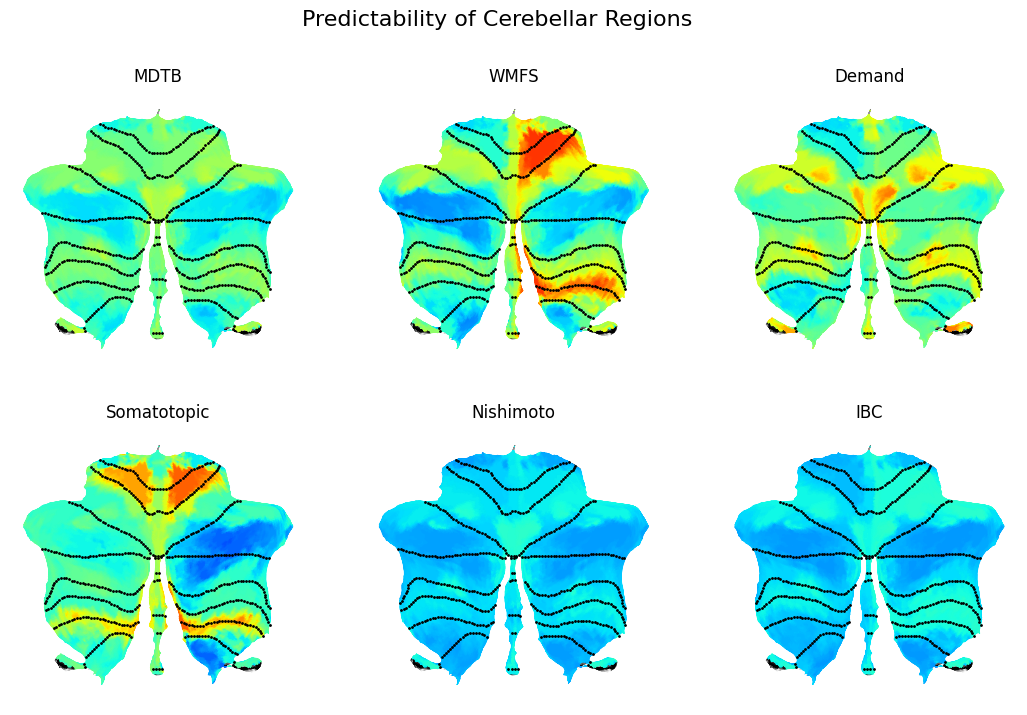

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
plt.suptitle('Predictability of Cerebellar Regions', fontsize=16)
for i, (dataset_name, R_map) in enumerate(R_map_dic.items()):
    plt.subplot(2, 3, i + 1)
    plot_cereb_data(R_map, atlas, cscale=[-0.2, 0.6])
    plt.title(dataset_name)